In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [3]:
#variables controlled by the user. Change these to fit your specific needs.

TRAIN_N_EVENTS = 10000 #Number of events to process for each class.
TEST_N_EVENTS = 3000 #Number of events to process for each class.
RES = 50 #resolution
CUT=True #Should cut be applied? Chooses different files if True.

#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]

"""
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"] #The exact labels in the hdf5 dataset for training
TEST_LABELS = [f"{label}_test" for label in LABELS] #The exact labels in the hdf5 dataset for testing
PLOT_LABELS = ["SPH_9", "BH_M8", "BH_M10", "BH_M12"] #Labels for plotting
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"] #The folders each hdf5 file is found in
"""

#Set data paths
if CUT:
    N_EVENTS = 10000
    TRAIN_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in LABELS]
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_3000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 10000
    TRAIN_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in LABELS]
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

#Set a unique name for the model
labelstring = '_'.join([str(elem) for elem in PLOT_LABELS])
if CUT:
    MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}_CUT"
else: MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}"
print(MODEL_NAME)
#Where to save the model
SAVE_FOLDER = "../results/models"
SAVE_PATH = f"{SAVE_FOLDER}/{MODEL_NAME}.pt"

#Setup GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate", "normalise"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )
#For plotting
ampl.use_atlas_style()   
#sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

resnet_1688645545_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT
Running on the GPU


### Load data

In [4]:
#Load data

testpaths = [Path(path) for path in TEST_DATAPATHS]
trainpaths = [Path(path) for path in TRAIN_DATAPATHS]

#Load lazily to save memory
test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)
train_data = Hdf5Dataset(trainpaths, LABELS, DEVICE, 
                        shuffle=True, filters=filters, transform=transforms, event_limit=TRAIN_N_EVENTS)

#Load directly to speed up
#test_data = load_datasets(testpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms=None)
#train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)


Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_STmin7_Nmin5_10000_events.h5.
Selecting 1000

In [5]:
x, y = train_data[0]
print(y)

tensor([0., 0., 1., 0., 0., 0.], device='cuda:0', dtype=torch.float64)


### View the data

[['SPH_9', 'SPH_9'], ['BH_n2_M10', 'BH_n2_M10'], ['BH_n4_M8', 'BH_n4_M8'], ['BH_n4_M10', 'BH_n4_M10'], ['BH_n4_M12', 'BH_n4_M12'], ['BH_n6_M10', 'BH_n6_M10']]
[[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]]
[[80, 5], [10011, 10094], [20081, 20060], [30092, 30042], [40028, 40083], [50054, 50050]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Image shape:  (50, 50, 3)


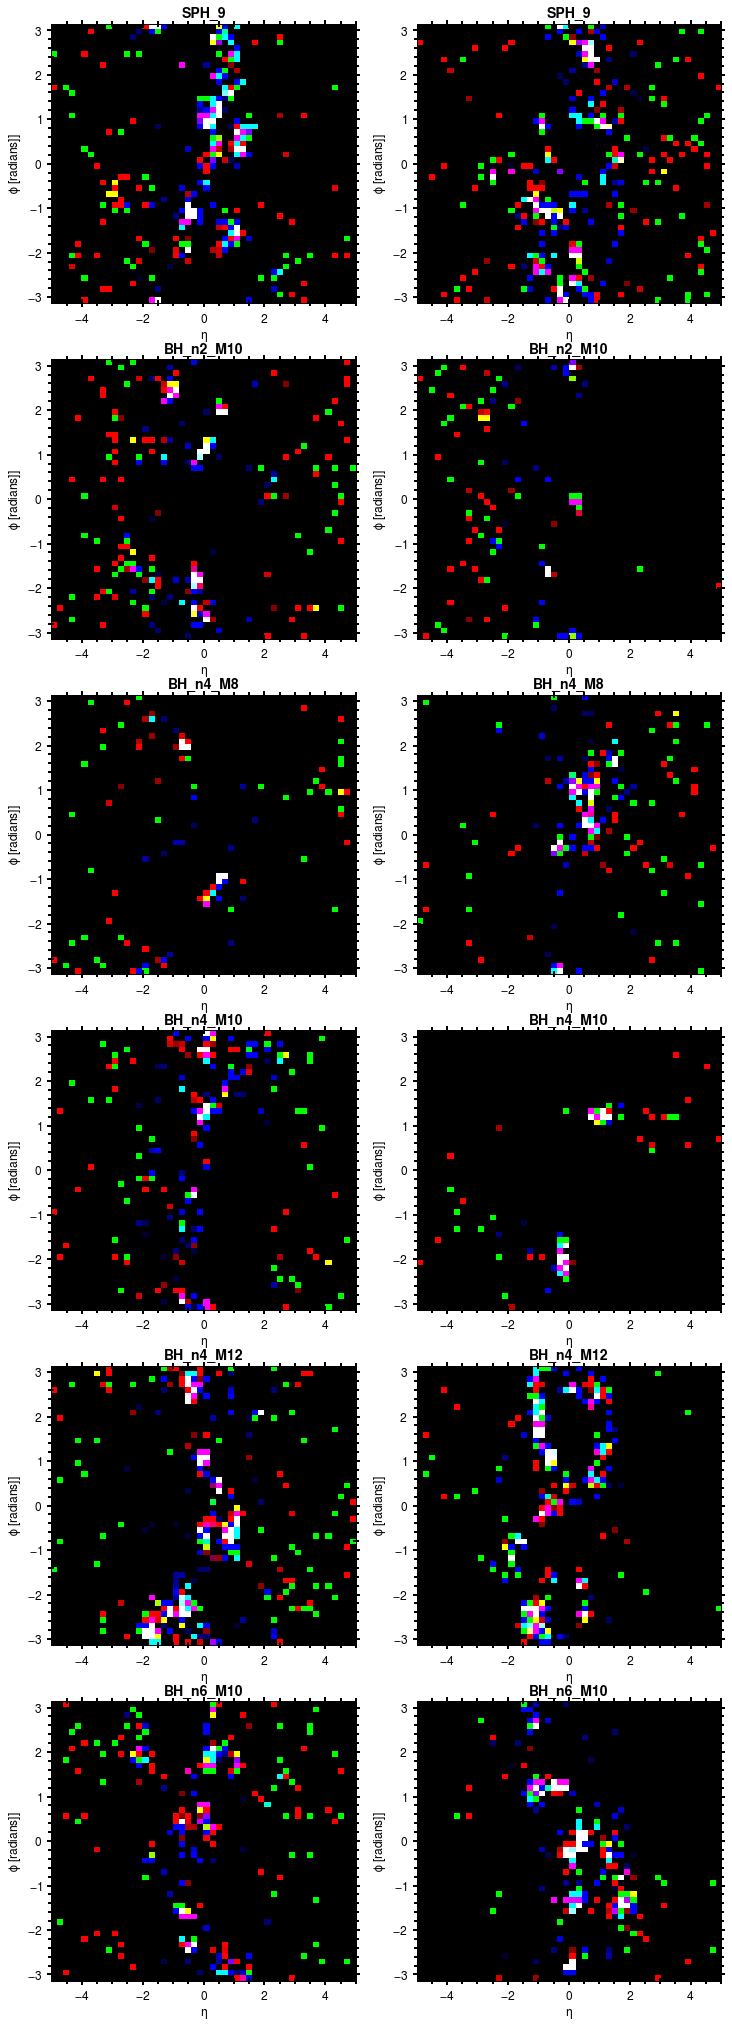

In [5]:
#Print some of the images
view_data(train_data, 2, CLASSES, PLOT_LABELS, RES, TRAIN_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 358.09686  438.80103  444.12146  444.19247  449.71927  471.07986
 1049.4047  1127.1176  1443.4197 ]
Looking at image 18922


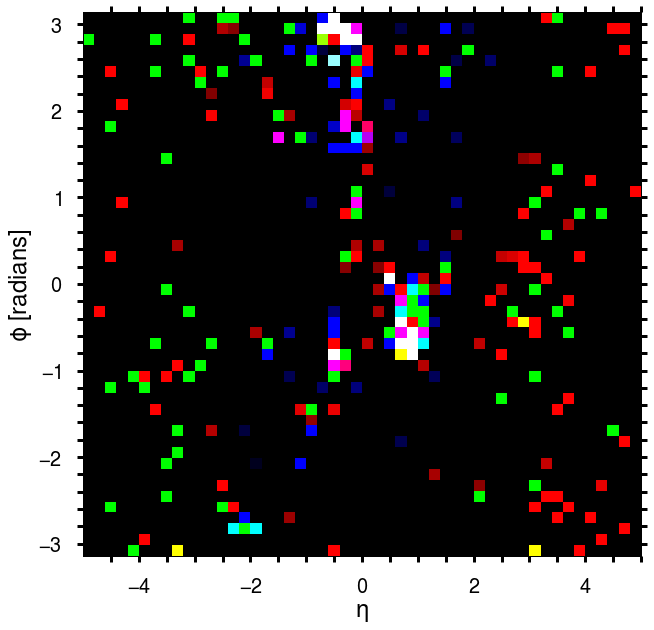

In [6]:
#Look at a random image more closely
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


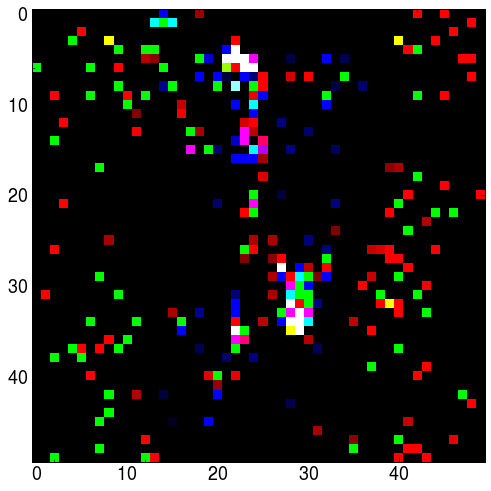

In [7]:
#Check augmentation on the same image
if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [8]:
#Create NN.
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)
#Test that nothing major is wrong.
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))
print(testlabel)

torch.Size([1, 3, 50, 50])
tensor([[-0.3647,  0.5880,  0.2864,  1.0371, -0.1800, -0.0543]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1., 0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)


In [13]:
#Set optimizer, learning rate scheduler and train the model
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.001*10, step_size_up=5, mode="exp_range", gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, test_data, 2**8, 40, RES, DEVICE, optimizer, scheduler)

100%|██████████| 40/40 [46:21<00:00, 69.54s/it]  


In [14]:
#Test that nothing major is wrong after training.
k = np.random.randint(0, len(test_data))
testimage, testlabel = test_data[k][0], test_data[k][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[ -1.4295,  -0.3483,   4.6151,  -0.1539, -11.1617,   0.0224]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0., 0., 1., 0., 0., 0.], device='cuda:0', dtype=torch.float64)


### Inspect the results

In [1]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
#axs[0].set_ylim(0.6, 1)
#axs[0].set_xlim(0)
axs[1].set_ylim(0, 1)

NameError: name 'plt' is not defined

### Predict on test set and check accuracy

In [16]:
truth, preds, losses, values = predict(resnet, test_data, CLASSES, 1, RES, DEVICE, return_loss=True, return_values=True)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 18000/18000 [02:07<00:00, 141.43it/s]


In [17]:
#Save model
torch.save(resnet.state_dict(), SAVE_PATH)

[0.903 0.033 0.055 0.001 0.006 0.002 0.092 0.369 0.156 0.048 0.193 0.142
 0.084 0.084 0.697 0.024 0.056 0.056 0.052 0.244 0.195 0.062 0.213 0.233
 0.015 0.039 0.035 0.007 0.877 0.027 0.034 0.204 0.197 0.057 0.213 0.295]


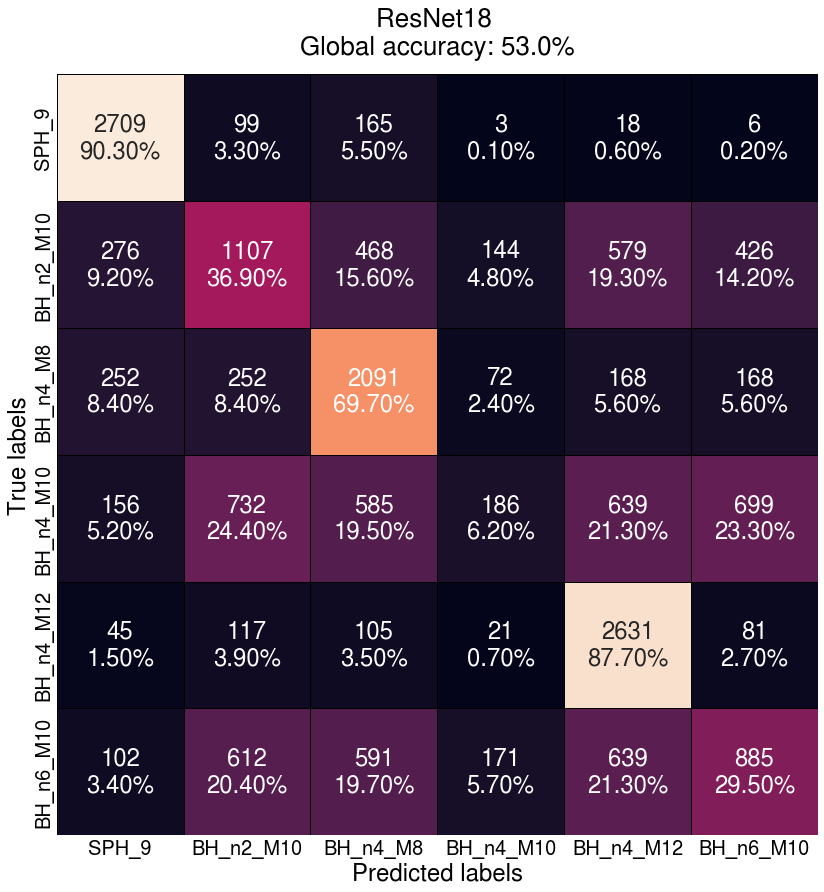

In [18]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(14, 14))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = np.round(cf_matrix, 3)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)

In [19]:
confusion["Event_ID"] = np.arange(0, len(confusion))
confusion["Correct_Pred"] = [confusion["Predictions"][i] == confusion["Truth"][i] for i in range(len(confusion))]
confusion["Losses"] = losses
confusion["Class_1_value"] = values[:,0]
confusion["Class_2_value"] = values[:,1]
confusion["Difference"] = abs(confusion["Class_1_value"] - confusion["Class_2_value"])
arg_chosen_value = np.asarray(preds.tolist())
chosen_value = [values[i, int(arg)].tolist() for i, arg in enumerate(arg_chosen_value)]
confusion["Best choice"] = chosen_value
#wrong_id = confusion[confusion["Correct_Pred"]==False]["Event_ID"].tolist()

In [20]:
confusion

,Truth,Predictions,Event_ID,Correct_Pred,Losses,Class_1_value,Class_2_value,Difference,Best choice
0,0.0,0.0,0,True,0.056306,0.945250,0.019180,0.926070,0.945250
1,0.0,0.0,1,True,0.059555,0.942184,0.016985,0.925199,0.942184
2,0.0,0.0,2,True,0.224276,0.799094,0.030968,0.768126,0.799094
3,0.0,0.0,3,True,1.008649,0.364711,0.223013,0.141699,0.364711
4,0.0,0.0,4,True,0.726171,0.483758,0.229133,0.254625,0.483758
...,...,...,...,...,...,...,...,...,...
17995,5.0,5.0,17995,True,1.192932,0.000101,0.288373,0.288272,0.303331
17996,5.0,3.0,17996,False,1.254341,0.000188,0.290568,0.290380,0.324465
17997,5.0,5.0,17997,True,0.974120,0.000002,0.270281,0.270279,0.377524
17998,5.0,5.0,17998,True,1.180074,0.000003,0.168020,0.168017,0.307256


In [21]:
confusion.sort_values(by=["Losses"], ascending=False, inplace=True, ignore_index=True)
#confusion.sort_values(by=["Correct_Pred"], ascending=True, inplace=True, ignore_index=True)
#print(confusion[confusion["Truth"]>0])
print(confusion)

       Truth  Predictions  Event_ID  Correct_Pred     Losses  Class_1_value  \
0        3.0          4.0     11100         False  14.722924   0.000000e+00   
1        0.0          5.0       886         False  10.534221   2.661007e-05   
2        3.0          4.0      9534         False   9.072228   2.559672e-31   
3        0.0          5.0      2276         False   8.323686   2.426997e-04   
4        3.0          4.0      9560         False   7.754386   1.759946e-25   
...      ...          ...       ...           ...        ...            ...   
17995    4.0          4.0     12335          True   0.000276   0.000000e+00   
17996    4.0          4.0     12026          True   0.000233   7.271272e-31   
17997    4.0          4.0     13897          True   0.000225   0.000000e+00   
17998    4.0          4.0     14242          True   0.000120   0.000000e+00   
17999    4.0          4.0     12754          True   0.000059   0.000000e+00   

       Class_2_value    Difference  Best choice  
0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for the hardest to classify image
[ 387.1365   406.05603  410.68976  527.0557   760.3249   787.6598
 1315.2897  1716.3478  2576.6038 ]
Looking at image 11100


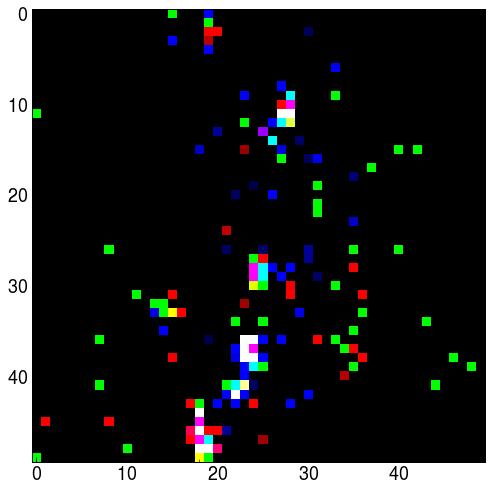

In [22]:
k = confusion["Event_ID"][0]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for the hardest to classify image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Text(0.5, 0, 'Softmax(y)')

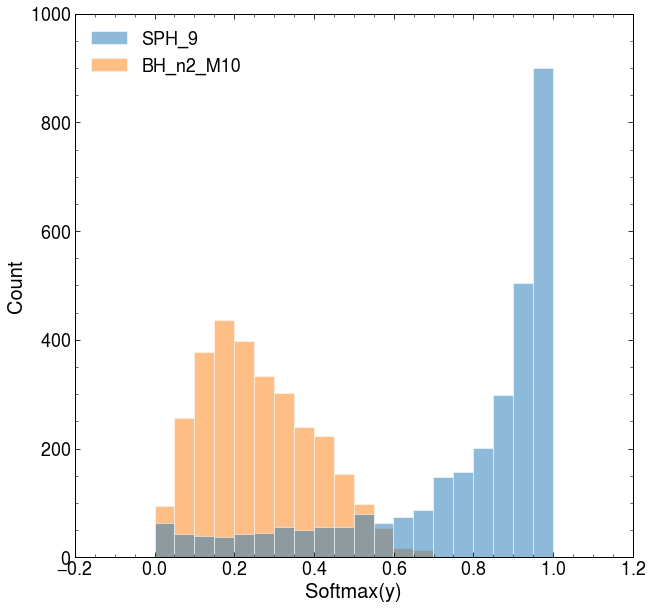

In [23]:
sph_softmax = confusion[confusion["Truth"]==0]["Class_1_value"]
bh_softmax = confusion[confusion["Truth"]==1]["Class_2_value"]
softmaxes = dict(zip(PLOT_LABELS, [sph_softmax, bh_softmax]))

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
sn.histplot(softmaxes, ax=ax, multiple="layer", stat="count", palette="tab10", bins=20)
sn.move_legend(ax, "upper left")
#ax.set_yscale("log")
ax.set_xlabel("Softmax(y)")